In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
Φ = norm.cdf

In [55]:
def discrete_derivative_kernel(xs):
    dxs = np.empty(len(xs)-1, dtype = xs.dtype)
    for i,x in enumerate(xs[1:]):
        dxs[i] = x - xs[i-1]
    return dxs

In [2]:
def black_scholes_GBM_valuation(t, T, St, r, K, σ):
    τ = T - t
    d1 = (np.log(St/K) + (r + 0.5*σ**2) * τ)/(σ * np.sqrt(τ))
    d2 = d1 - σ*np.sqrt(τ)
    return St * Φ(d1) - np.exp(-r*τ)*K*Φ(d2)

def call_option_payoff(asset_price, strike_price):
    return max(asset_price - strike_price, 0.0)

def d1(t, T, St, K, r, σ):
    τ = T-t
    return (np.log(St/K) + (r + 0.5*σ**2) * τ)/(σ * np.sqrt(τ))

def d2(t, T, St, K, r, σ):
    τ = T-t
    return d1(t, T, St, K, r, σ) - σ*np.sqrt(τ)

def Δ(t, T, St, K, r, σ):
    return Φ(d1(t, T, St, K, r, σ))

In [9]:
def euler_GBM(adjustment_frequency, initial_stock_price, strike_price, maturity_time, rf_interest_rate, σ, n_sim, σ_Δ = None):
    if not σ_Δ:
        σ_Δ = σ
    T = maturity_time
    M = adjustment_frequency
    S0 = initial_stock_price
    K = strike_price
    r = rf_interest_rate
    
    S_timeseries = np.zeros(shape=(n_sim, np.uint64(M+1)))  # we need this type-conversion here
    S_timeseries[:,0] = S0
    Δ_values = np.zeros(shape=(n_sim,np.uint64(M+1)))
    Δ_values[:,0] = Δ(0, T, S0, K, r, σ_Δ)
    Φ = norm.cdf
    
    dt = T/M
    # results in division by zero when t = T
        
    for sim in range(n_sim):
        for m in range(M):
            t = (m+1)*dt
            zm = np.random.normal(loc=0.0, scale=1.0)
            St = S_timeseries[sim][m] * (1.0 + r*dt  + σ*np.sqrt(dt)*zm)
            S_timeseries[sim][m+1] = St
            Δ_values[sim][m+1] = Δ(t, T, St, K, r, σ_Δ)
    
    return S_timeseries, Δ_values

In [10]:
adjustment_frequencies = np.array([365] + list(reversed(range(100, 301, 50))) + [52])
T = 1.0
σ = 0.2
S0 = 100.0
K = 99.0
n_sim = 10
r = 0.06
# euler_GBM(adjustment_frequency, initial_stock_price, strike_price, maturity_time, rf_interest_rate, σ, n_sim):
asset_price_data, Δ_data = euler_GBM(adjustment_frequencies[0], S0, K, T, r, σ, n_sim)

/tmp/ipykernel_6530/1698807027.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(St/K) + (r + 0.5*σ**2) * τ)/(σ * np.sqrt(τ))


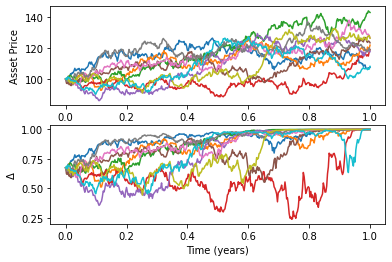

In [29]:
fig,ax = plt.subplots(2,1)
ts = np.linspace(0, T, adjustment_frequencies[0] + 1)
ax[1].set_xlabel("Time (years)")
ax[1].set_ylabel("Δ")
ax[0].set_ylabel("Asset Price")
for i,asset_price_timeseries in enumerate(asset_price_data):
    ax[0].plot(ts, asset_price_timeseries)
    ax[1].plot(ts, Δ_data[i])

In [30]:
asset_price_adj_rate_data = []
for M in adjustment_frequencies:
    args = (M, S0, K, T, r, σ, n_sim)
    asset_price_adj_rate_data.append(euler_GBM(*args))

/tmp/ipykernel_6530/1698807027.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(St/K) + (r + 0.5*σ**2) * τ)/(σ * np.sqrt(τ))


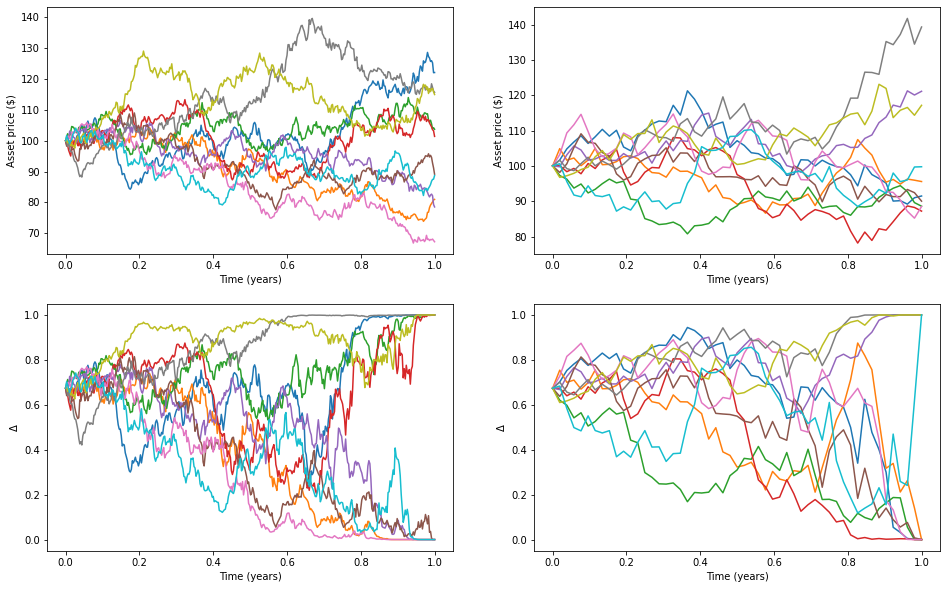

In [49]:
fig,ax = plt.subplots(2,2, figsize=(16,10))

M_daily = adjustment_frequencies[0]
M_weekly = adjustment_frequencies[-1]

daily_asset_price_data, daily_Δ_data = asset_price_adj_rate_data[0]
weekly_asset_price_data, weekly_Δ_data = asset_price_adj_rate_data[-1]

for a in ax.flatten():
    a.set_xlabel("Time (years)")

for a in ax[0,:]:
    a.set_ylabel("Asset price ($)")
    
for a in ax[1,:]:
    a.set_ylabel("Δ")
ts_weekly = np.linspace(0, T, M_weekly+1)
ts_daily = np.linspace(0, T, M_daily+1)

for i,daily_asset_price_timeseries in enumerate(daily_asset_price_data):
    ax[0][0].plot(ts_daily, daily_asset_price_timeseries)
    ax[1][0].plot(ts_daily, daily_Δ_data[i])
for i,weekly_asset_price_timeseries in enumerate(weekly_asset_price_data):
    ax[0][1].plot(ts_weekly, weekly_asset_price_timeseries)
    ax[1][1].plot(ts_weekly, weekly_Δ_data[i])

In [68]:
daily_ap_timeseries_sample = daily_asset_price_data.flatten()
daily_Δ_timeseries_sample = daily_Δ_data.flatten()
weekly_ap_timeseries_sample = weekly_asset_price_data.flatten()
weekly_Δ_timeseries_sample = weekly_Δ_data.flatten()

/tmp/ipykernel_6530/879537013.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


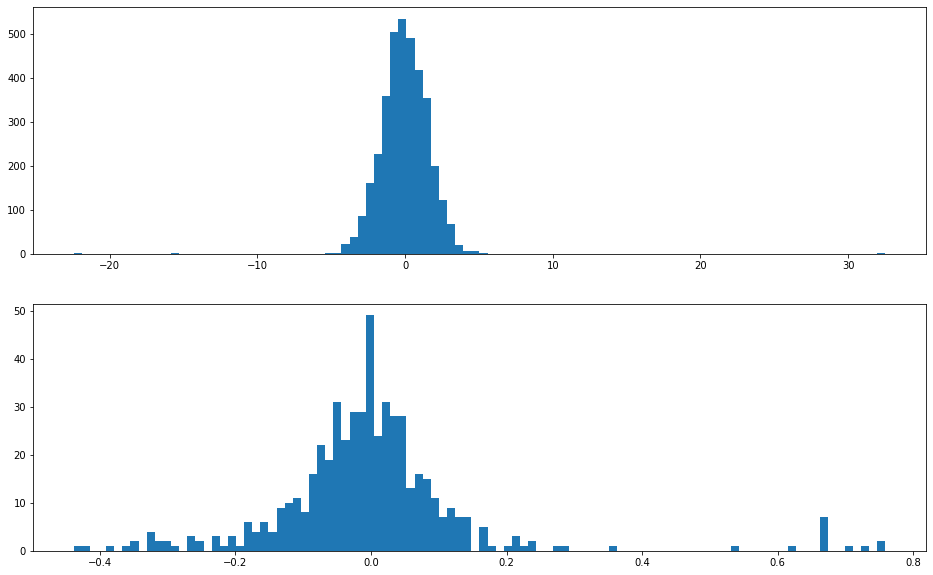

In [72]:
dΔ_daily = discrete_derivative_kernel(daily_ap_timeseries_sample)
dΔ_weekly = discrete_derivative_kernel(weekly_Δ_timeseries_sample)
fig,ax = plt.subplots(2,1, figsize=(16,10))
ax[0].hist(dΔ_daily, bins=100)
ax[1].hist(dΔ_weekly, bins=100)
fig.show()

(3660,)